In [1]:
import cvxpy as cp
import numpy as np
import seaborn as sns
import scipy
import time
from tqdm import tqdm

import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

# Numerical optimization packages: CVXPY and SciPy


Plan:

0. Standard problem classes
1. CVXPY
2. SciPy

# Optimization problem standard classes

## Linear programming (LP)
\begin{equation}
    \begin{aligned}
    \min_{x\in\mathbb{R}^n} &c^\top x,\\
    \text{s.t. }&Ax=b,\\
    &Gx\leq h,
\end{aligned}
\end{equation}
where $A\in\mathbb{R}^{m\times n}, G\in\mathbb{R}^{k\times n}.$


- Example: maximum flow problem
<!-- \begin{equation}
    \begin{aligned}
    \min_{f, \lambda} &-\lambda,\\
    \text{s.t. }&Lx=\lambda d,\\
    &Gx\leq h,
\end{aligned}
\end{equation} -->
<!-- 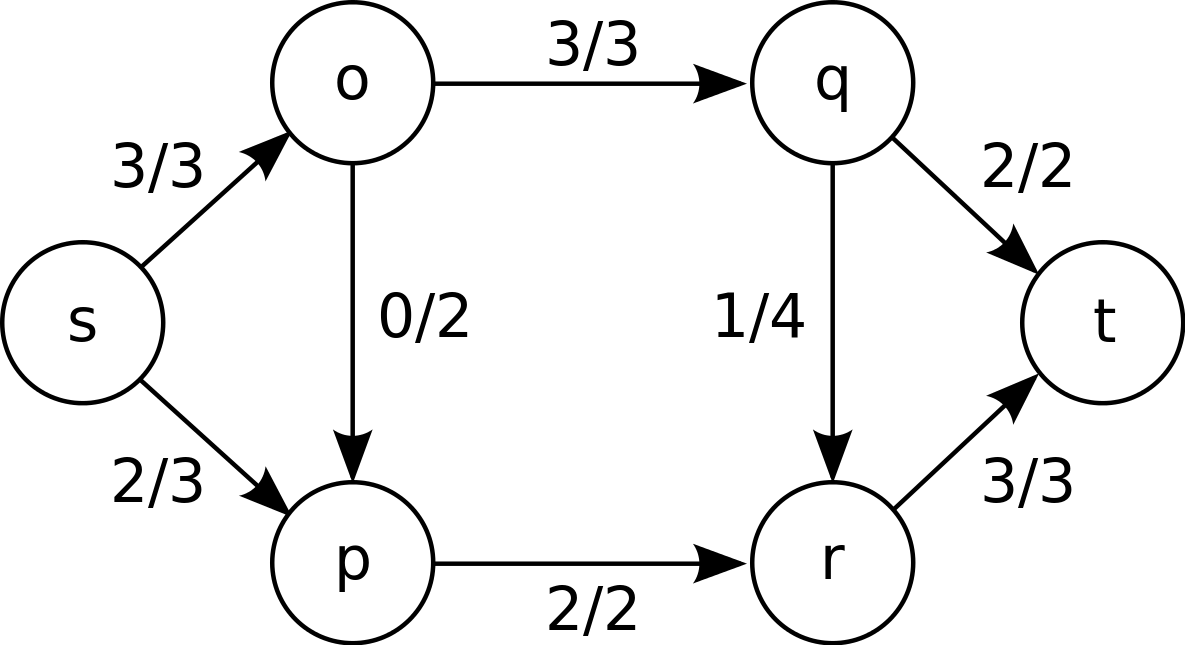 -->
<div style="text-align: center;">
    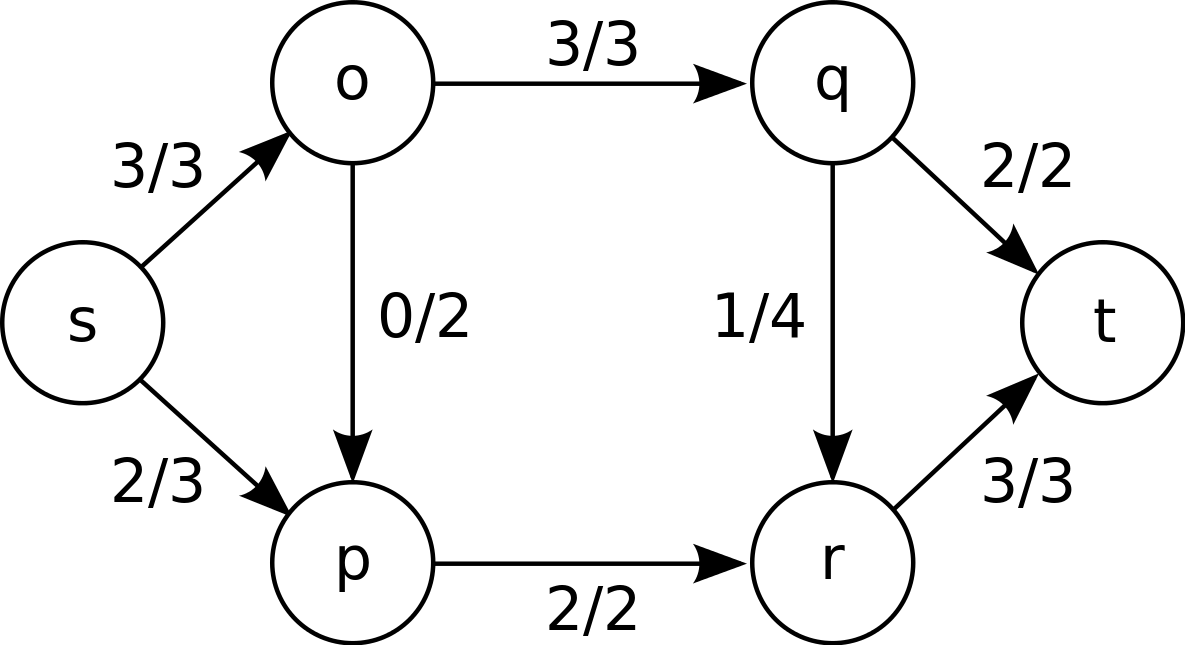
</div>


\begin{align}
&\min_{f \geq 0, \lambda} -\lambda
\\ \text{s.t. }&  f \leq b \quad 
\\ & \sum_eA_{ve}f_e = \begin{cases}-\lambda, v \text{ is source} \\ \lambda, v \text{ is target} \\ 0, \text{otherwise}\end{cases} \qquad \forall v=1,\ldots,n,
\end{align}
where $f$ is a vector of edge flows, $b$ is a vector of capacities, $\lambda$ is the amount of flow (which is maximized), $A$ is the incidence matrix of the graph


- Effective algorithm: simplex method and its variations

## Quadratic programming (QP)
\begin{equation*}
    \begin{aligned}
        \min_{x\in \mathbb{R}^n} & \frac{1}{2}x^\top A x + c^\top x\\
    \text{s.t. }&Ex=f,\\
    &Gx\leq h,
    \end{aligned}
\end{equation*}

## Second-Order Cone Programming (SOCP)
\begin{align*}
\min_{x \in \mathbb{R}^n}  &c^\top x\\
\text{s.t. } &Ax=b\\
&\|G_i x - h_i\|_2 \leq e_i^\top x + f_i, i=\overline{1, M}.
\end{align*}


# Semidefinite Programing (SDP)
\begin{align*}
    \min_{X\in\mathbb{S}^n} \text{tr}(CX)\\
    \text{s.t. }&\text{tr}(A_i X)=b_i, i=\overline{1,m}\\
    &X \succeq 0.
\end{align*}


Actually these classes are of increasing levels of generality
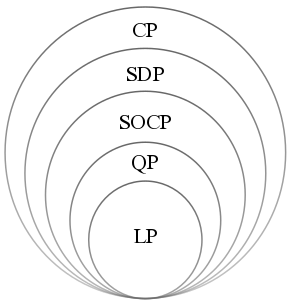



There are other standard problem classes, e.g. allowing for exponential functions in constraints

# CVXPY

<!-- https://www.cvxpy.org/ [официальный миникурс по cvxpy](https://www.cvxgrp.org/cvx_short_course/docs/index.html), 
https://www.youtube.com/watch?v=GfLyfLKoMIU - Бойд объясняет, как работает cvxpy -->

- Open-source modeling language for convex optimization in Python



- Structural optimization paradigm: an explicit problem formulation is assumed, not a black-box approach


- For small- to medium-dimension problems (~$10^3-10^5$ variables) on average, it runs 2-10 times slower than a custom solver, but it is 10+ times faster in programming


- CVXPY does not solve problems by itself, but provides a user-friendly interface to formulate a problem and then transforms it into a format that solvers can understand (using a standard optimization problem class as the intermediate representation) 


- In addition to convex problems, CVXPY also supports mixed integer-convex problems, quai-convex problems and geometric programming 


Usage example: Find the minimal l1-norm solution to a system of linear equations
$\newcommand{\R}{\mathbb R}$$$\begin{align}
&\min_{x\in \R^d} \|x\|_1 \\
\text{s.t. }& Ax = b \\
\end{align}$$


In [34]:
m, n = 15, 20
A, b = np.random.randn(m, n), np.random.randn(m)

x = cp.Variable(n)
f = cp.norm1(x)  # declare the objective funciton
constraints = [A @ x == b]  # declare the constraints 
prob = cp.Problem(cp.Minimize(f), constraints)
prob.solve()

print("Optimal objective value:", prob.value)
print("Constraints deviation norm:", np.linalg.norm(A @ x.value - b))
print("Primal and dual problem solution:") 
_ = print(x.value), print(constraints[0].dual_value)

Optimal objective value: 4.664261575979899
Constraints deviation norm: 1.9683876856575316e-13
Primal and dual problem solution:
[ 3.44068757e-01 -1.97567364e-10 -1.14033491e-02  2.15204075e-01
 -4.99320014e-01 -2.31347229e-01 -3.36252628e-12 -3.56375673e-01
 -3.97299503e-01  6.83706556e-01 -7.02020441e-03  4.58915443e-10
 -2.10776209e-10 -3.72480146e-01  2.99261200e-01  3.74873305e-01
  4.30289786e-01  3.85520422e-01  2.20223286e-10  5.60913544e-02]
[ 0.10828778  0.43059903 -0.18724542  0.64011772  0.58894696  0.14123496
  0.9902913  -1.20433066  0.02485112 -0.14878996 -1.00806649  0.00981013
  1.14912117  0.64465423  0.1121253 ]


We obtained the solution of the primal and dual problems without
- Implemetation of functions that compute the (sub)gradient / hessian
- Constructing the dual problem and writing out the conjugate functions
- Selection of the optimization algorithm

Next, we will figure out how this works and how to use it.

## Disciplined Convex Programming (DCP)
https://dcp.stanford.edu/

- DCP - (theoretical) framework for describing convex minimization problems, the core of CVXPY



- Problems formulated in DCP can be efficiently and equivalently transformed into a standard (LP, SDP, etc.) form and passed to a solver. CVXPY does this automatically.

- DCP uses sufficient, but not necessary, conditions for convexity, which means that sometimes one must manually transform a problem into DCP form before writing it down in CVXPY. (CVXPY requires that convex problems comply with DCP rules.)

<!-- Коническая задача - стандартная промежуточная форма для записи задач оптимизации -->

### A general convex composition rule
- $h(f_1(x), \ldots, f_n(x))$ is a convex function if $h$ is a jointly convex function, and for each index $i$:
    - either $h$ is a non-decreasing function of the $i$-th argument and $f_i$ is convex
    - or $h$ is a non-increasing function of the $i$-th argument and $f_i$ is concave
    - or $f_i$ is affine ($f_i(x) = a^\top x + b$)

- The same rule applies to concave combinations; simply replace "convex" with "concave" in the text above.

**Доказательство**
$\newcommand{\uo}[3]{\underset{#1}{\overset{#2}{#3}}}$
For definiteness suppose that $f_i$ are convex

$\newcommand{\vf}{\vec f}$ 
$$\vf(\alpha x_1 + (1-\alpha) x_2) \stackrel{\text{convexity of} ~f_i}\leq \alpha \vf(x_1) + (1-\alpha) \vf(x_2),$$ there the inequlity is component-wise. Therefore

$$h(\vf(\alpha x_1 + (1-\alpha) x_2)) \stackrel{\text{monotonicity of}~h}{\leq} h(\alpha \vf(x_1) + (1-\alpha) \vf(x_2))
\stackrel{{convexity of}~h}{\leq} \alpha h(\vf(x_1)) + (1-\alpha) h(\vf(x_2))$$

The case where $f_i$ is concave and $h$ is non-increasing with respect to the $i$-th argument is analogous to the one described above. In the case where $f_i$ is affine, the first two inequalities are replaced with equalities.



This is the only rule you need to know to use CVXPY. Other operations that preserve convexity are derived from it. For example:
- The sum of convex functions is convex because $f_1(x) + f_2(x) = \text{sum}(f_1(x), f_2(x))$, where $h = \text{sum}$ is a convex function that is non-decreasing with respect to its arguments.
- Pointwise maximum: $\max \{f_1(x), f_2(x), \ldots, f_n(x)\}$ is similar.


### What is this for?
A small set of **(~20) functions** with known properties (convexity, monotonicity) **+ the rule of convex composition** allows for the formulation and proof of convexity in a **vast number of problems**.

Technically, it is also necessary to track the definiteness of function values since monotonicity can depend on the sign of the argument: for example, $\|x\|_1, \|x\|_2$ are increasing with respect to $x_i$ when $x_i \geq 0$ and decreasing when $x_i \leq 0$.


### Example of function analysis using DCP

$$\frac{(x-y)^2}{1-\max(x,y)}, \quad x < 1,~y<1$$

This function is convex on the specified set:
- $u^2/v$ is a convex function, monotonically decreasing with respect to $v$ when $v > 0$



- (leaves) $x$, $y$, $1$ are affine functions
- $\max(x, y)$ is a convex function, $x-y$ is affine.

- $u = (x-y)$ is affine, $v = 1 - \max(x, y)$ is concave and positive on the function's domain.

Tree from https://dcp.stanford.edu/analyzer
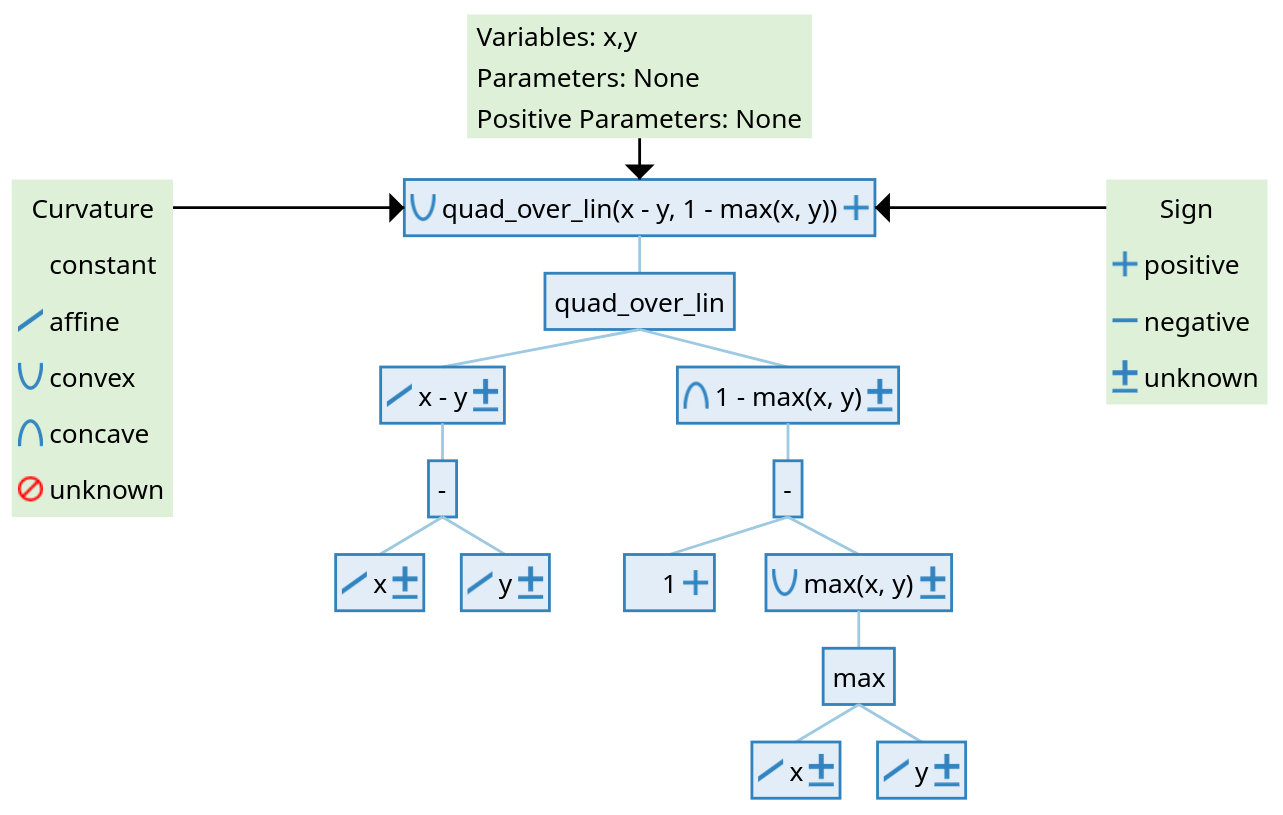

### Formal definition of a problem in DCP form
A problem satisfies DCP rules if it
- has no more than one **objective** of the form
    - `minimize {scalar convex expression}` or
    - `maximize {scalar concave expression}`
    
and
- has 0 or more **constraints** of the form
    - `{convex expression} <= {concave expression}` or
    - `{concave expression} >= {convex expression}` or
    - `{affine expression} == {affine expression}`
   
and convexity/concavity/affinity can be established by the general rule of convex composition


### Conversion to DCP form

Not every expression corresponding to a convex function satisfies the DCP rules. For example, $x^2 - \frac12 x^2$ does not pass because there is no rule for the subtraction of convex functions.

**Example 1.** $f(x) = \sqrt{1+x^2}$ is a convex function.

Let's try to minimize it in CVXPY.

In [35]:
x = cp.Variable()
f = (x**2 + 1) ** 0.5
cp.Problem(cp.Minimize(f)).solve()  # DCPError: Problem does not follow DCP rules. The objective is not DCP

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(power(var2511, 2.0) + 1.0, 0.5)
However, the problem does follow DQCP rules. Consider calling solve() with `qcp=True`.

The square root is a concave increasing function, and $1 + x^2$ is a convex function. The general rule of convex composition cannot be applied, so $f(x)$ does not satisfy the DCP rules.

However, this function can be expressed in a different form: $f(x) = \left\|\begin{pmatrix}1\\x\end{pmatrix}\right\|_2$.
The norm is a convex function, and $\begin{pmatrix}1\\x\end{pmatrix}$ is an affine function of $x$. By the rule of convex composition, $f(x)$ is convex.

In [38]:
x = cp.Variable()
f = cp.norm(cp.hstack((1, x)))
cp.Problem(cp.Minimize(f)).solve()  # ok

1.0

**Пример 2.**

$\newcommand{\R}{\mathbb R}$$$\begin{align}
&\min_{x\in \R} x + 2 \\
\text{s.t. }& 5 = 2/x \\
& x > 0
\end{align}$$


The problem does not satisfy the DCP rules because the equality constraint involves a function that is not affine.

In [40]:
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x + 2), [5 == 2 * cp.inv_pos(x)])
prob.solve()  # DCPError: Problem does not follow DCP rules. Constraints are not DCP

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
2.0 @ power(var2565, -1.0) == 5.0 , because the following subexpressions are not:
|--  2.0 @ power(var2565, -1.0) == 5.0

Let's make the substitution $t = 1/x > 0$. Since $x = 1/t$, and this function is convex for $t > 0$, we obtain a minimization problem of a convex function with affine constraints.

In [6]:
t = cp.Variable()
prob = cp.Problem(cp.Minimize(cp.inv_pos(t) + 2), [5 == 2 * t])
prob.solve()  # ok

2.399999999999572

**Пример 3.**


$$\begin{align}
&\min_{x \in \R} x + 2 \\
\text{s.t. }& 5 \leq 2/x^2 \\
\end{align}$$


The problem does not satisfy DCP rules because a convex function appears on the right side of the inequality $\leq$ in the constraint.

In [7]:
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x + 2), [5 <= 2 * x**-2])
prob.solve()  # DCPError: Problem does not follow DCP rules. Constraints are not DCP

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
5.0 <= 2.0 @ power(var89, -2.0) , because the following subexpressions are not:
|--  5.0 <= 2.0 @ power(var89, -2.0)
However, the problem does follow DQCP rules. Consider calling solve() with `qcp=True`.

Lets multiply both sides of the inequality by $x^2$ 

In [8]:
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x + 2), [5 * x**2 <= 2])
prob.solve()  # ok

1.3675444680250728

## How CVXPY transforms problems
### General scheme
- For each atomic function $f(x)$ in the library ([complete list](https://www.cvxpy.org/api_reference/cvxpy.atoms.html)), a representation of this function as the solution to a certain conic problem is known.

- CVXPY traverses the arithmetic expression tree and replaces functions with their representations as an optimizaiton problem in a standard class of optimization problems (LP, SDP, ...).



- The result is a problem in a standard class


- Depending on the class to which the original problem has been transformed, a suitable solver is selected, and the final transformation of the problem is performed to the form defined by the solver's API.

- DCP guarantees that the resulting problem is equivalent to the original one.

### A bit more detail
- For atomic functions $f(x)$ CVXPY knows their representations as an optimization problem of standard class
$$\begin{align}
&\min_{y} c^\top x + d^\top y + e \\
\text{s.t. }& A\begin{pmatrix}x\\y\end{pmatrix} = b, \quad \begin{pmatrix}x\\y\end{pmatrix} \in K,
\end{align}$$
where $K$ is one of the standard cones: ($x \geq 0$) $\R^n_+$ (in the case of reduction to LP), second-order cone, exponential cone, etc.


- Functions in the problem are replaced with their optimization representations
    - For each atomic function $f(x)$, a variable $y$ is added
    - Occurrences of $f(x)$ in the problem are replaced with $c^\top x + d^\top y + e$
    - Constraints from the optimization representation of $f(x)$ are added to the current set of constraints


- The result is a problem with a linear objective function and conic as well as affine constraints.

### Example

$\newcommand{\R}{\mathbb R}$$$\begin{align}
&\min_{x\in \R^d} \max\{\|x\|_1, \|x\|_2^2 \} \\
\text{s.t. }& Ax = b \\
\end{align}$$

- Optimization representations of atomic functions
    - $$\max_{i=1,\ldots,n} x_i = \min\{y ~|~ x_i \leq y,~i=1,\ldots, n,~ y \in \R\}  \quad \text{(LP)}$$
    - $$\|x\|_1 = \sum_{i=1}^d |x_i|, \quad |x_i| = \max\{x_i, -x_i\} \quad \text{(LP)}$$
    - $$\|x\|_2^2 = \min\left\{t~|~ \|(2x, t-1)^\top\|_2 \leq t+1,~ t\geq 0\right\}  \quad \text{(SOCP)}$$
    because $\|(2x, t-1)^\top\|_2 \leq t+1 \Leftrightarrow \|x\|_2^2 \leq t$


- Recursively replace atomic functions with their optimizaiton representations
    - Outer maximum
    $$\max\{\|x\|_1, \|x\|_2^2\} =
    \begin{array}{ll}
     &\min_{p} p
    \\\text{s.t.} &\|x\|_1 \leq p
    \\&\|x\|_2^2 \leq p
    \end{array}$$

    - l2-norm squared
    $$
    \max\{\|x\|_1, \|x\|_2^2\} =
    \begin{array}{ll}
    &\min_{p, t} p 
    \\~~\text{s.t.} &\|x\|_1 \leq p
    \\& t \leq p
    \\&\|(2x, t-1)^\top\|_2 \leq t+1,
    \\& t \geq 0
    \end{array}$$


- l1-norm
$$
\max\{\|x\|_1, \|x\|_2^2\} = 
\begin{array}{ll}
 &\min_{p, t, y} p &
\\~~\text{s.t. } &\sum_{i=1}^d y_i \leq p
\\& x \leq y
\\& -x \leq y
\\& t \leq p
\\&\|(2x, t-1)^\top\|_2 \leq t+1,
\\& t \geq 0
\end{array}$$


- All that's left is to add $\min_x$ and the original affine constraint $Ax=b$ - we obtain an equivalent transformation of the problem into a Second-Order Cone Programming (SOCP) problem. 

- CVXPY performs all these transformations automatically.

In [44]:
m, n = 15, 20
A, b = np.random.randn(m, n), np.random.randn(m)

x = cp.Variable(n)
f = cp.maximum(cp.norm1(x), cp.sum_squares(x))  # declare objective
constraints = [A @ x == b]  # declare constraints
prob = cp.Problem(cp.Minimize(f), constraints)
prob.get_problem_data(cp.SCS)  # result of transformations
# prob.solve()

({'param_prob': <cvxpy.reductions.dcp2cone.cone_matrix_stuffing.ParamConeProg at 0x7f7dc8036e10>,
  'dims': (zero: 15, nonneg: 42, exp: 0, soc: [22], psd: [], p3d: []),
  'c': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
  'A': <79x42 sparse matrix of type '<class 'numpy.float64'>'
  	with 425 stored elements in Compressed Sparse Column format>,
  'b': array([ 0.32590132, -0.63880403,  0.09282396,  1.13677876, -0.45925213,
         -1.36897445,  1.14817408, -1.32671091,  1.10581991,  0.06633847,
          0.03284987,  1.46001401,  0.84744432,  0.35359555, -2.45240274,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.  

 ## Summary
- CVXPY frees users from the need to understand how to convert problems into standard form.
Once the reduction of a complicated function such as $x_{[1]} + \ldots + x_{[r]}$ to an LP problem was incorporated into CVXPY, users no longer need to think about it - the reduction will be applied automatically.

- Instead of knowing a multitude of reductions and manually applying them, the user only needs to worry about formulating the problem into a DCP (Disciplined Convex Programming) form, which essentially boils down to the single rule of convex composition.


## CVXPY Interface
Consider the problem
\begin{align}
\min_{x\in \R,y \in \R} ~ & (x-y)^2 \\
 \mbox{s.t. } & x+y=1 \\
& x-y \geq 1 \\
\end{align}

In [45]:
# Creating scalar variables
x = cp.Variable()
y = cp.Variable()

# Constraints
constraints = [x + y == 1,
               x - y >= 1]

print("Constraints: ", constraints, "\n") # these are not bools, they are expressions

# Objective function
obj = cp.Minimize((x - y)**2)

# Creating the problem
prob = cp.Problem(obj, constraints)

# Solving the problem.
# Side effect: variable values, prob.status and prob.value fields, constraint object fields are updated
prob.solve()

print("Status:", prob.status)  # "optimal" means the problem was successfully solved
print("Optimal value:", prob.value)  # the optimal value of the objective function
print("Optimal vars (x,y):", x.value, y.value)  # optimal values of the variables (solution to the problem)
print()

# The solution to the dual problem (optimal values of the Lagrange multipliers) can be found in constraint.dual_value.
print("Optimal (x + y == 1) dual variable: u =", constraints[0].dual_value)
print("Optimal (x - y >= 1) dual variable: lambda =", constraints[1].dual_value) 


Constraints:  [Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ()))] 

Status: optimal
Optimal value: 1.0
Optimal vars (x,y): 1.0 1.570086213240983e-22

Optimal (x + y == 1) dual variable: u = 0.0
Optimal (x - y >= 1) dual variable: lambda = 2.0


### Supported Solvers and Problem Classes
It is worth noting that CVXPY itself does not solve the problem but instead calls external solvers.

The full version of the table can be found [here](https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver).


|                | LP | QP | SOCP | SDP | EXP | POW | MIP |
|----------------|----|----|------|-----|-----|-----|-----|
| CLARABEL    | X  | X  | X    |  X  |  X  |  X  |     |
| GLPK        | X  |    |      |     |     |     |     |
| GLPK_MI     | X  |    |      |     |     |     | X   |
| OSQP        | X  | X  |      |     |     |     |     |
| CPLEX       | X  | X  | X    |     |     |     | X   |
| ECOS        | X  | X  | X    |     | X   |     |     |
| GUROBI      | X  | X  | X    |     |     |     | X   |
| MOSEK       | X  | X  | X    | X   | X   | X   | X** |
| CVXOPT      | X  | X  | X    | X   |     |     |     |
| SCS         | X  | X  | X    | X   | X   | X   |     |
| SCIP        | X  | X  | X    |     |     |     | X   |
| SCIPY       | X  |    |      |     |     |     | X*  |

You can change the **solver** that CVXPY calls using the `solver` parameter in the `problem.solve` method.

By default, CVXPY calls the solver that is most specialized for the given type of problem. For instance, for SOCP, it calls ``ECOS``. SCS can solve all problems (except for mixed-integer programs). For QP, CVXPY uses OSQP.

CVXPY relies on the open-source solvers ECOS, CVXOPT, and SCS. Additional solvers are supported but must be installed separately.

Main open-source solvers: ``ECOS``, ``OSQP``, ``SCS``.

Commercial solvers: ``CPLEX``, ``GUROBI``, ``XPRESS``, ``MOSEK``.

Different solvers have differently named parameters (e.g., maximum number of iterations). See the [list of parameters](https://www.cvxpy.org/tutorial/advanced/index.html#setting-solver-options) for more information.

### Infeasible and Unbounded Problems
If, during `problem.solve()`, it is discovered that the problem is infeasible (there are no feasible points, the constraints define an empty set) or unbounded (the value of the objective function can tend to $-\infty$ for a minimization problem), the `problem.status` field will be set to `'infeasible'` or `'unbounded'`, respectively.

Example of an infeasible problem:
\begin{align}
\min ~ & x\\
 \text{s.t. } & x\geq 1 \\
 & x\leq -1 \\
\end{align}

Example of an unbounded problem:
\begin{align}
\min ~ & x\\
\end{align}


In [11]:
print("Infeasible problem \n")
x = cp.Variable()
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
result = prob.solve()
print("Optimal value of the function:", result)
print("Solution:", x.value)
print("Status:", prob.status, "\n\n")

print("Unbounded problem \n")
prob = cp.Problem(cp.Minimize(x))
result = prob.solve()

print("Optimal value of the function:", result)
print("Solution:", x.value)
print("Status:", prob.status)

Infeasible problem 

Optimal value of the function: inf
Solution: None
Status: infeasible 


Unbounded problem 

Optimal value of the function: -inf
Solution: None
Status: unbounded


### Variables
Variables can be scalar, vector, or matrix. Higher dimensions are not yet supported; they need to be handled manually.

In [12]:
# Scalar variable
a = cp.Variable()

# Vector variable of dimension 5
x = cp.Variable(5)

# Matrix variable of dimensions 5 x 1
X = cp.Variable((5, 1))

### Parameters
Parameters can be used instead of constants if you plan to solve the problem multiple times with different parameter values. In this case, the problem will not be recompiled. You can also compute derivatives of the solution with respect to parameter values.

In [13]:
# Nonnegative scalar parameter
m = cp.Parameter(nonneg=True)

# Vector parameter of indefinite sign (by default).
c = cp.Parameter(5)

# Matrix parameter with nonpositive entries
G = cp.Parameter((4, 7), nonpos=True)

# Assigning a value to a parameter
G.value = -np.ones((4, 7))

### Constraints

Defined using the operators `==`, `<=`, and `>=`. 
You are allowed and encouraged to use inequalities between vectors and matrices, which will be understood component-wise.

Strict inequalities `<` and `>` cannot be used as they are of little practical sense.

Chained comparisons (`a <= b <= c`, `a == b == c`) are also not supported.

### Integer Variables

To solve problems with discrete variables, simply set the flags `boolean` or `integer` when creating the variables.

In [14]:
x = cp.Variable(10, boolean=True)
Z = cp.Variable((5, 7), integer=True)

## Problem Examples
For more examples: https://www.cvxpy.org/examples/index.html

### Finding the Minimum Volume Enclosing Ellipsoid (The Löwner-John Ellipsoid)
Consider an ellipsoid defined by the matrix $X \in \mathbb{S}^n_{++}$ as $E=\left\{a \in \mathbb{R}^n \mid \|Xa + b\|\leq 1\right\}$. Equivalently, it can be defined as the pre-image of the unit ball under the action of the mapping defined by the matrix $X$: $E=\left\{a \mid Xa\in B_1(0)\right\}$. In this case, we can calculate its volume:

$$V_E = \iiint_{x \in E} dx = \iiint_{x| Xx\in B_1(0)} dx= \iiint_{y \in B_1(0)} \det\left(\frac{\partial X^{-1} y}{\partial y}\right) dy=\det (X^{-1}) V_{B_1(0)}$$

Now consider the problem of constructing an ellipsoid of minimum volume such that the points $\{a_i\}_{i=1}^m$ lie within it, i.e. $\|Xa_i\|\leq 1$. Minimizing the volume $V_E$ is equivalent to minimizing $\log V_E = \log \det (X^{-1}) + \log V_{B_1(0)}=-\log\det X + c$. Then, discarding the additive constant, we get the minimization problem:

$$\min_{X \in \mathbb{S}^n_{++}} -\log\det X$$

$$\text{s.t. } \|Xa_i + b\| \leq 1, i=\overline{1,m}$$

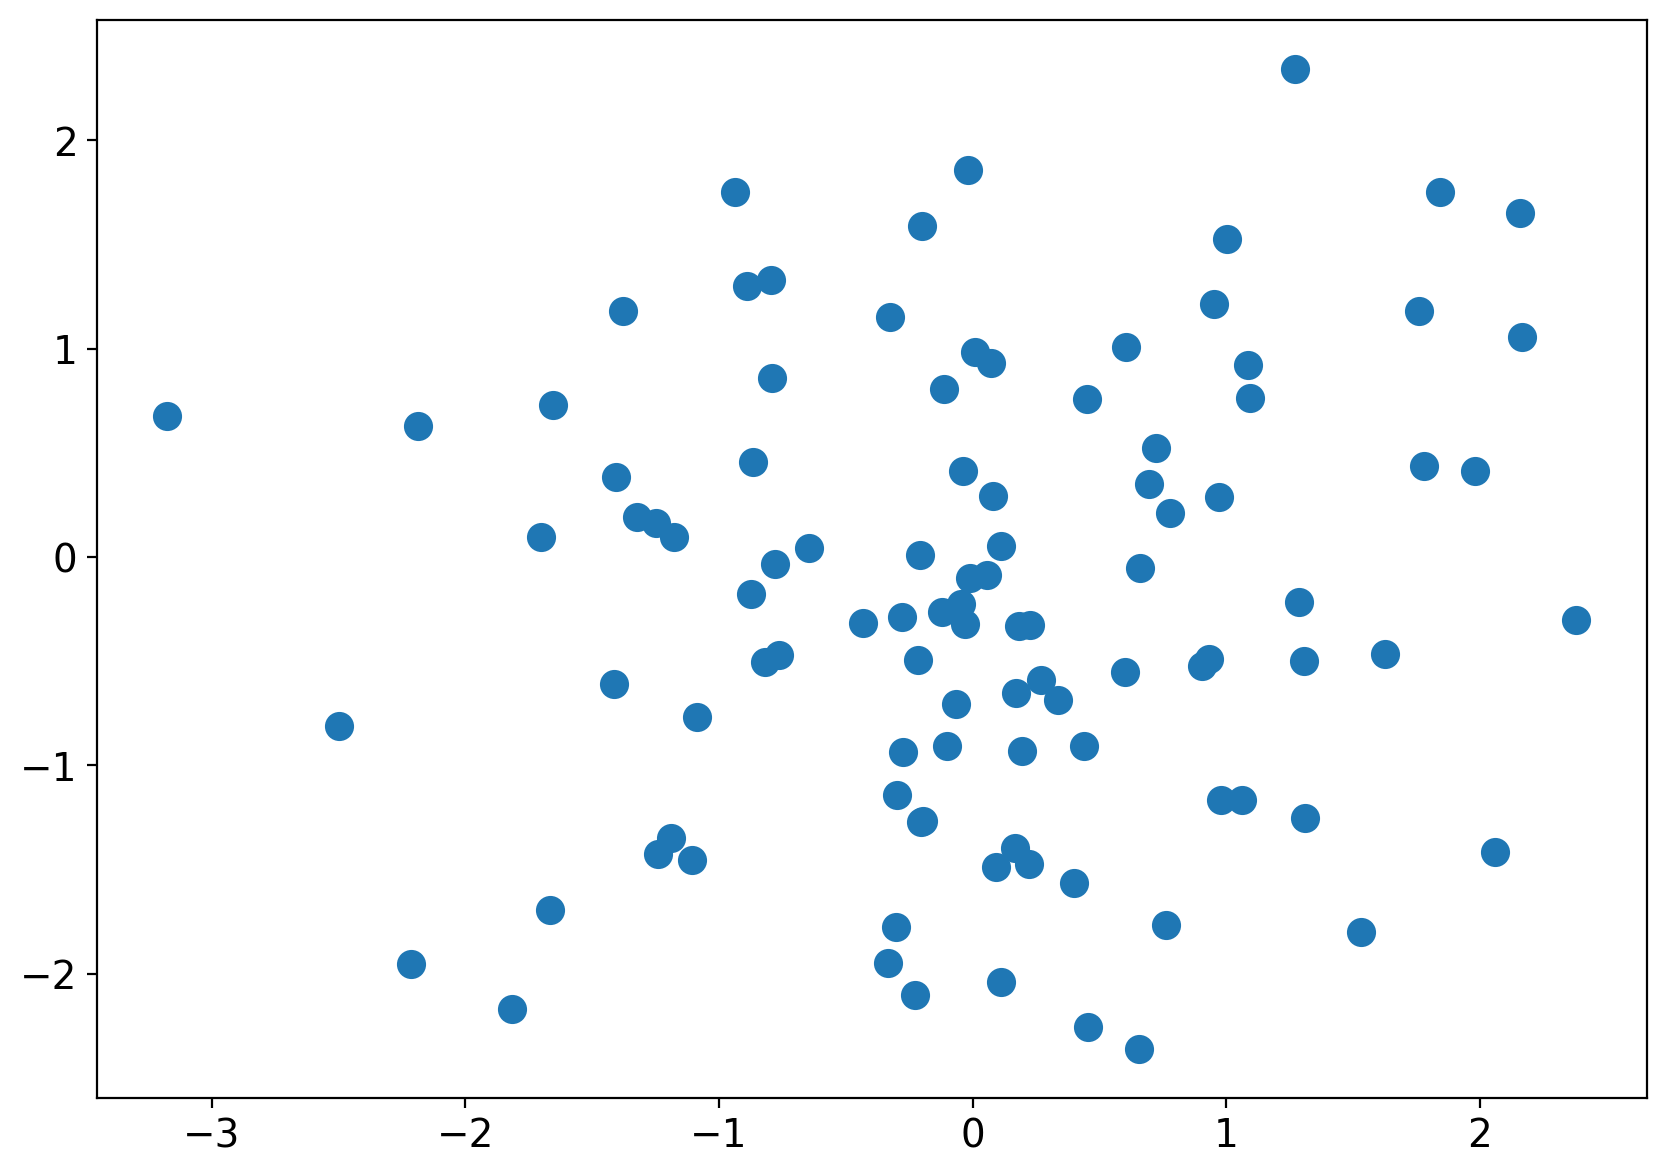

In [46]:
# np.random.seed(1)

n, m = 2, 100
A = np.random.randn(m, n)

plt.figure(figsize=(10, 7))
plt.scatter(A[:, 0], A[:, 1], s=90)

In [47]:
X = cp.Variable((n, n))
b = cp.Variable(n)

obj = cp.Minimize(-cp.log_det(X))

constraints = [cp.norm(X @ a + b) <= 1 for a in A]

problem = cp.Problem(obj, constraints)
_ = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Dec 04 07:51:56 PM: Your problem has 6 variables, 100 constraints, and 0 parameters.
(CVXPY) Dec 04 07:51:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 04 07:51:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 04 07:51:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 04 07:51:56 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 04 07:51:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

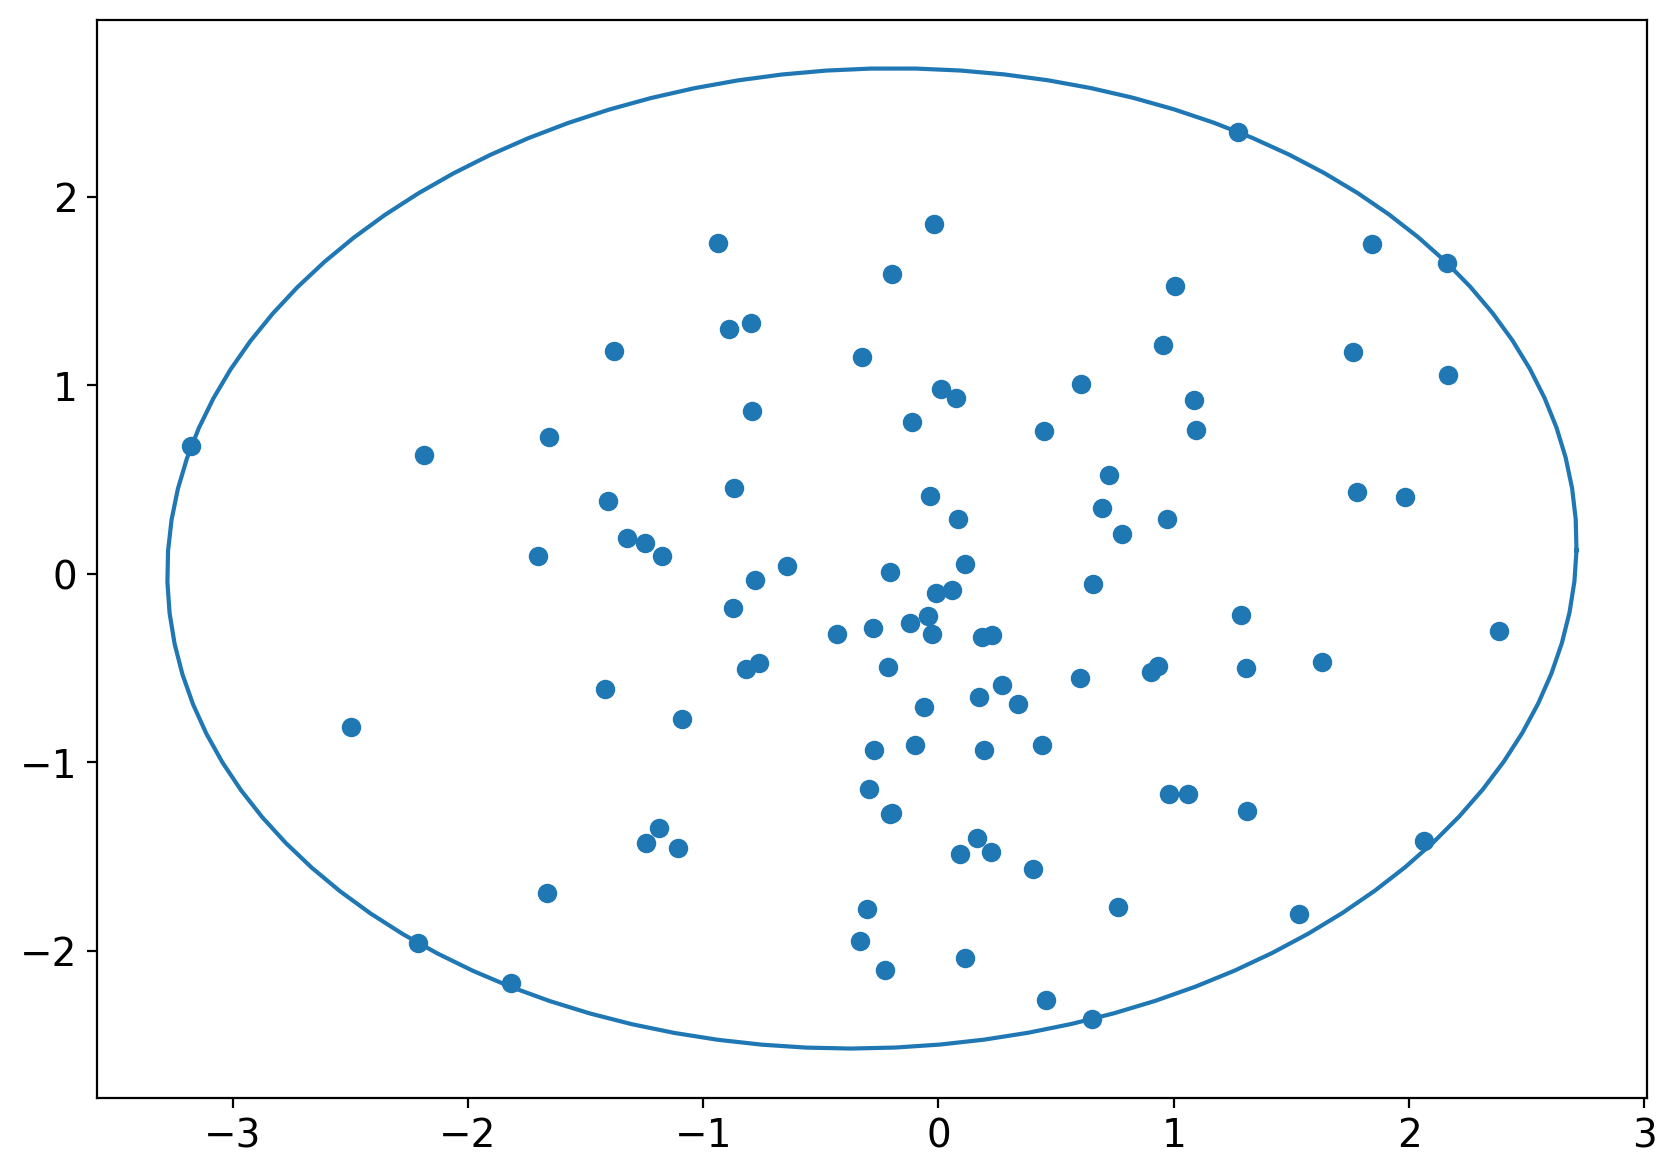

In [48]:
L = np.linalg.inv(X.value)
plt.figure(figsize=(10, 7))
plt.scatter(A[:, 0], A[:, 1])
phi = np.linspace(0, 2 * np.pi, num=100)
xy = np.vstack((np.cos(phi), np.sin(phi))) - b.value.reshape(-1, 1)
ellips = L.dot(xy)
plt.plot(ellips[0, :], ellips[1, :])

 ### The Meeting Point Problem
Two bodies move with friction on a plane. Their initial coordinates and velocities are given.

We can control their accelerations. The goal is to find such accelerations (controls) for both bodies so that their final states are the same, and the total energy expended is minimized.



- Discretize the equations of dynamics for a linear system (for a single body):

$$
x_{t+1} = Ax_t + Bu_t
$$
$$
m \frac{v_{t+1} - v_t}{\tau} \approx -\eta v_t + u_t \quad \frac{p_{t+1} - p_t}{\tau} \approx v_{t},
$$
    Here, $x_t$ is the overall state vector comprised of spatial coordinates $p_t = (p^x_t, p^y_t)$ and the velocity vector $v_t = (v^x_t, v^y_t)$.
    $u_t$ is the acceleration vector, $\eta$ is the coefficient of friction, and $\tau$ is the time step.

- The approximate system is given as:

$$
v_{t+1} = \left(1 - \frac{\tau}{m}\eta \right)v_t + \frac{\tau}{m}u_t \quad p_{t+1} = p_t + \tau v_t
$$

- Representation in standard form:

$$
x_{t} = \begin{bmatrix} p^x_t \\ p^y_t \\ v^x_t \\ v^y_t \end{bmatrix} \quad A = \begin{bmatrix} 1 & 0 & \tau & 0 \\ 0 & 1 & 0 & \tau \\ 0 & 0 & 1 - \frac{\tau}{m}\eta & 0\\ 0 & 0 & 0 & 1 - \frac{\tau}{m}\eta  \end{bmatrix} \quad B = \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ \frac{\tau}{m} & 0 \\ 0 & \frac{\tau}{m} \end{bmatrix}
$$


- We will minimize the sum of the squares of controls (accelerations), which to some extent corresponds to minimizing energy and is a standard criterion in optimal control theory.
- Then, the rendezvous problem of two bodies is formulated as follows:
$$
\begin{align*}
& \min_{\substack{u, w \in \mathbb{R}^{2\times T}\\x, z \in \mathbb{R}^{2\times (T+1)}}} \sum_{i=1}^T \|u_i\|_2^2 + \|w_i\|_2^2 \\
\text{s.t. } & x_{t+1} = Ax_t + Bu_t, \; t = 1,\ldots,T\\
& z_{t+1} = Cz_t + Dw_t, \; t = 1,\ldots,T\\
& x_T = z_T
\end{align*}
$$


In [18]:
# Define the system's parameters
m1 = 1
eta1 = 0.1
m2 = 1
eta2 = 1
tau = 0.01
T = 100

# Compose the matrix of dynamic system equaitons
A = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta1 * tau / m1, 0], 
              [0, 0, 0, 1 - eta1 * tau / m1]])
B = np.array([[0, 0],
             [0, 0],
             [tau / m1, 0],
             [0, tau / m1]])

C = np.array([[1, 0, tau, 0], 
              [0, 1, 0, tau], 
              [0, 0, 1 - eta2 * tau / m2, 0], 
              [0, 0, 0, 1 - eta2 * tau / m2]])
D = np.array([[0, 0],
             [0, 0],
             [tau / m2, 0],
             [0, tau / m2]])

In [19]:
# Set the initial conditions
x0 = np.array([0, 0, 10, 3])
z0 = np.array([10, 0, 10, -1])

In [20]:
x, z = cp.Variable((4, T + 1)), cp.Variable((4, T + 1))
u, w = cp.Variable((2, T)), cp.Variable((2, T))

cost = cp.sum_squares(u) + cp.sum_squares(w)
constraints = [x[:, 1:] == A @ x[:, :-1] + B @ u, z[:, 1:] == C @ z[:, :-1] + D @ w]  # Уравнения динамики
constraints += [x[:, T] == z[:, T], x[:, 0] == x0, z[:, 0] == z0]  # Начальные условия

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=0)

60727.0929563204

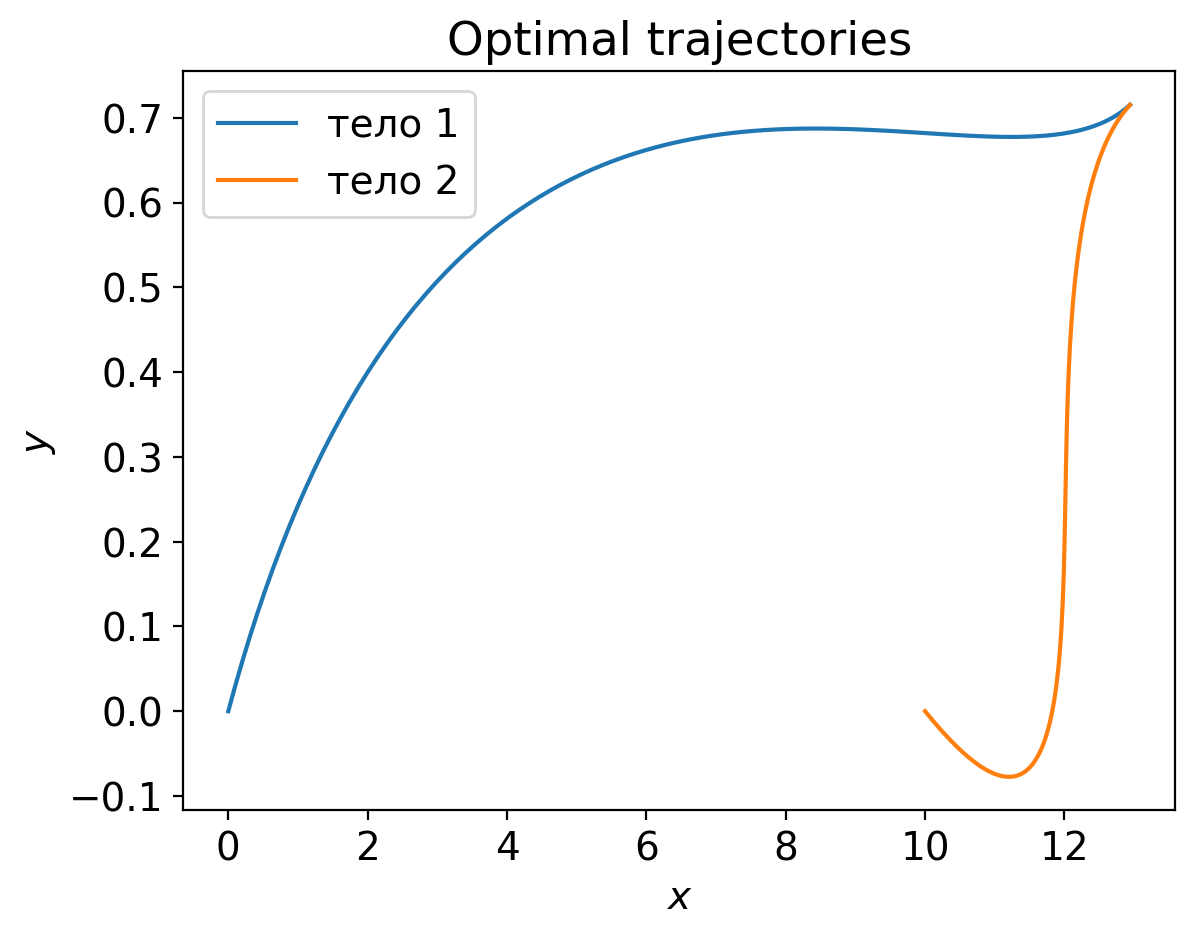

In [21]:
plt.plot(x.value[0, :], x.value[1, :], label="тело 1")
plt.plot(z.value[0, :], z.value[1, :], label="тело 2")
plt.title("Optimal trajectories")
plt.legend()
_ = plt.xlabel(r"$x$"), plt.ylabel(r"$y$")

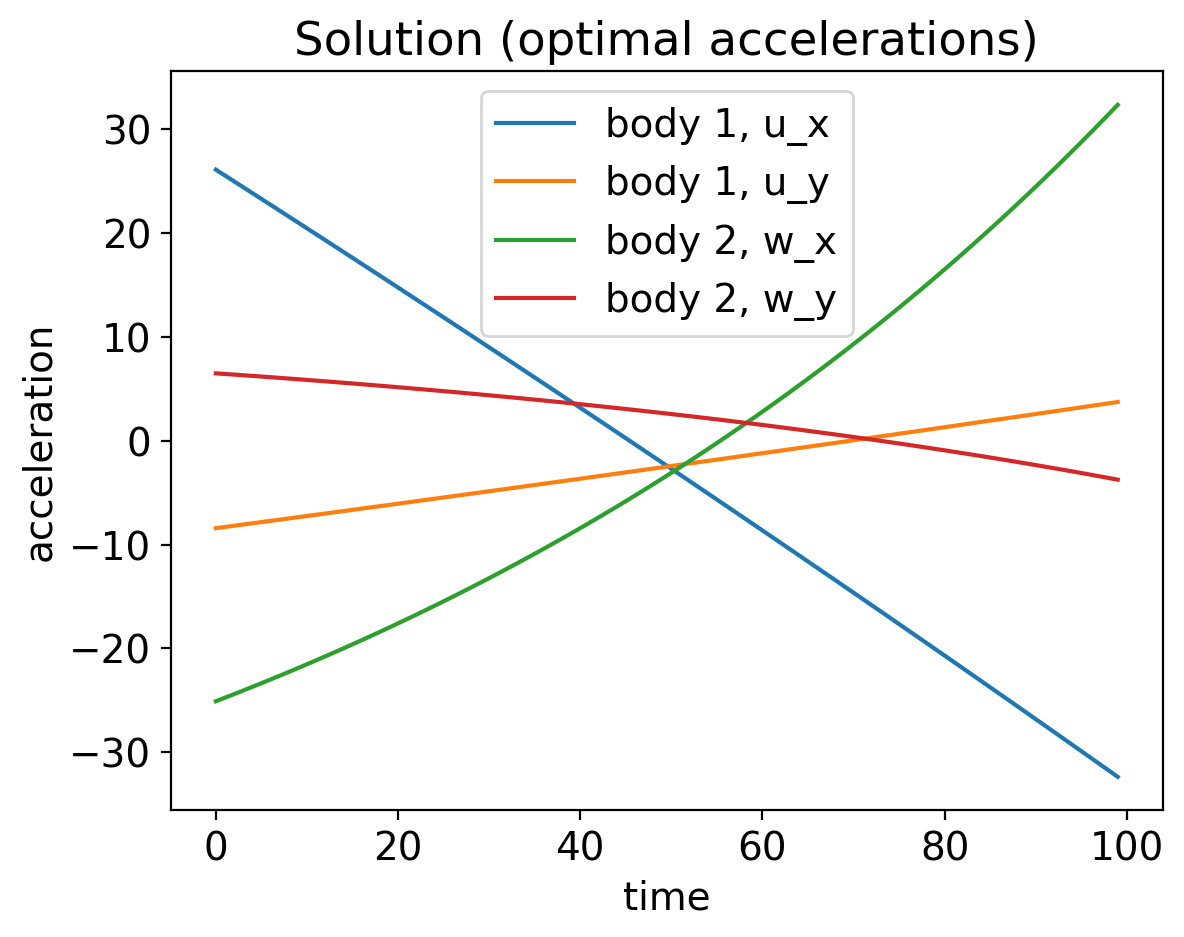

In [22]:
plt.title("Solution (optimal accelerations)")

plt.plot(u.value[0, :], label="body 1, u_x")
plt.plot(u.value[1, :], label="body 1, u_y")
plt.plot(w.value[0, :], label="body 2, w_x")
plt.plot(w.value[1, :], label="body 2, w_y")
plt.xlabel("time")
plt.ylabel("acceleration")

_ = plt.legend()


# SciPy.optimize
https://docs.scipy.org/doc/scipy/reference/optimize.html

- Functions (except `linprog` and `MILP`) accept a black-box input.
- One must implement gradients and Hessians themselves.
- Directly related to optimization are:
    - The `minimize_scalar` function for one-dimensional minimization / line search.
    - The `minimize` function for local/convex multidimensional minimization.
    - `linprog` and `MILP` for LP and mixed-integer linear programming. Used as a solver in CVXPY.
    - Functions from the global optimization group: `basinhopping`, `differential_evolution`, and others.

## Local Optimization
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Highlights from the documentation:

- All algorithms are included in one `minimize` function and can be specified through the optional `method=` argument, or selected automatically.

- It is mandatory to pass a zeroth-order oracle `fun=` and an initial point `x0=`. One may also pass gradient computation functions `jac=` and Hessian computation functions `hess=`, or a product of the Hessian with a vector `hessp=`. If not provided, finite-difference schemes may be applied for their computation.

- Box constraints on the variables can be specified through the `bounds=` argument, as well as linear or nonlinear constraints through the `constraints=` argument.

- Different algorithms work with different oracles and vary in their ability to handle constraints. If no algorithm is specified through the `method=` argument, SciPy will use `BFGS`, `L-BFGS-B`, or `SLSQP` depending on the presence of constraints.

### Example: Rosenbrock Function

[wiki](https://en.wikipedia.org/wiki/Rosenbrock_function)

In the two-dimensional case, it looks like this (on Wikipedia there is a more contrasting plot)

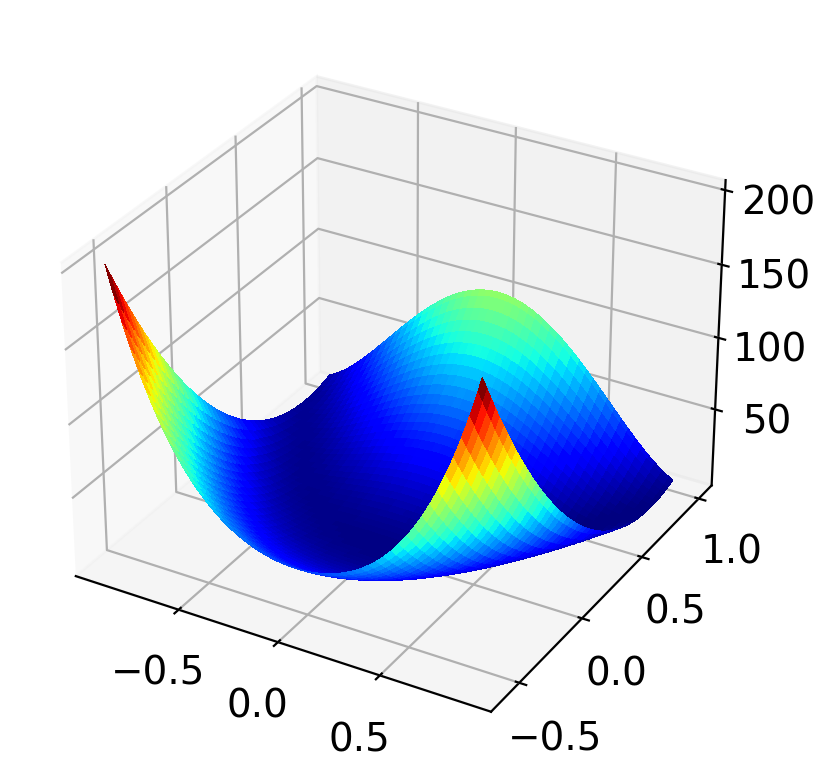

In [23]:
from scipy.optimize import minimize, rosen, rosen_der
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(-0.9, 0.9, 100)
y = np.linspace(-0.6, 1, 100)
X, Y = np.meshgrid(x, y)
ax = plt.subplot(111, projection='3d')
ax.plot_surface(X, Y, rosen([X, Y]), cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

In [24]:
x0 = np.random.random(20)

# Zero-order method
%timeit minimize(rosen, x0, method='Nelder-Mead', tol=1e-6)

# BFGS (quasi-newton method), gradient is approximated by finite differences
%timeit minimize(rosen, x0, method='BFGS', options={'gtol': 1e-6})

# BFGS, exact gradient
%timeit minimize(rosen, x0, method='BFGS', jac=rosen_der, options={'gtol': 1e-6})


146 ms ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
71.1 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.2 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Global Optimization: TSP

Let's apply SciPy to the Traveling Salesman Problem (TSP). We will find the shortest cycle on a complete graph on a plane with Euclidean distance between the vertices.

SciPy's global optimization methods are designed for minimizing functions on $\mathbb{R}^n$, so we need a way to convert a vector from $\mathbb{R}^n$ into a cycle on the graph. One option is to define the order of visiting vertices to be equal to the order of the components of the vector after sorting it, i.e., performing an argsort operation.

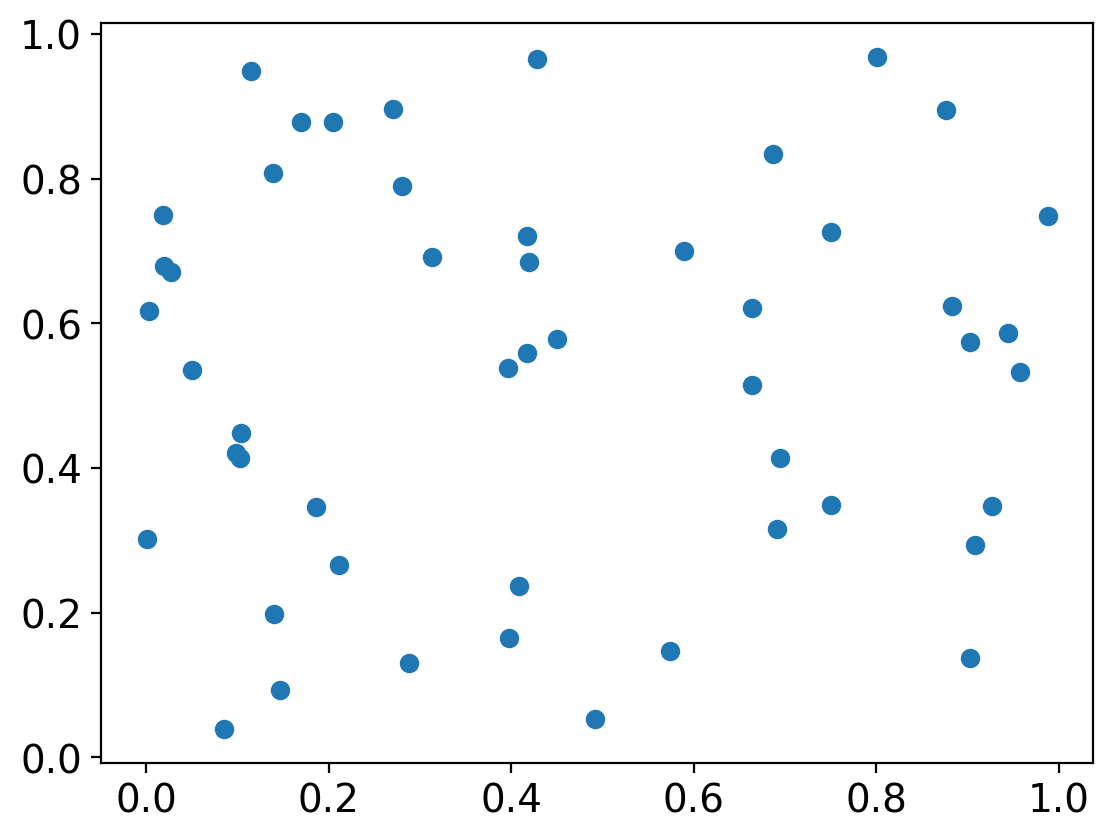

In [25]:
from scipy.optimize import dual_annealing, differential_evolution

np.random.seed(1)

# Generate random points
n = 50
points = np.random.random((n, 2))

plt.scatter(*points.T)

path len = 4.100231981215019


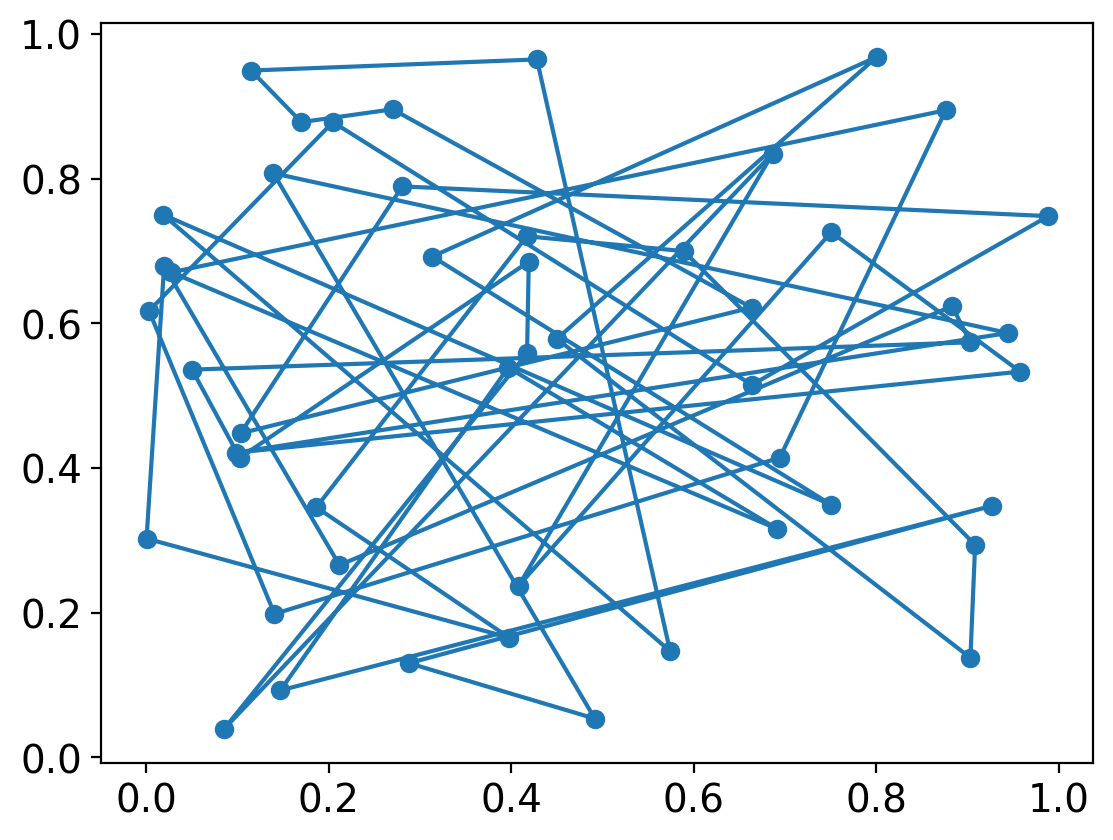

In [26]:
def path_len(path: np.ndarray):
    return (np.linalg.norm(points[np.roll(path, -1)] - points[path])).sum()

# Convert a vector from R^n to a path 
def x_to_path(x: np.ndarray):
    return np.argsort(x)

# Objective function, defined on R^n
def cost(x: np.ndarray):
    return path_len(x_to_path(x))

# Plot vector from R^n as a cycle
def plot_x(x: np.ndarray):
    print(f"path len = {cost(x)}")
    path = x_to_path(x)
    plt.scatter(*points.T)
    plt.plot(*(points[np.hstack((path, path[0]))].T))
    plt.show()

# Initial guess
x0 = np.random.random(n)
plot_x(x0)

100%|██████████| 10/10 [01:10<00:00,  7.06s/it]

CPU times: user 1min 7s, sys: 3.33 s, total: 1min 10s
Wall time: 1min 10s


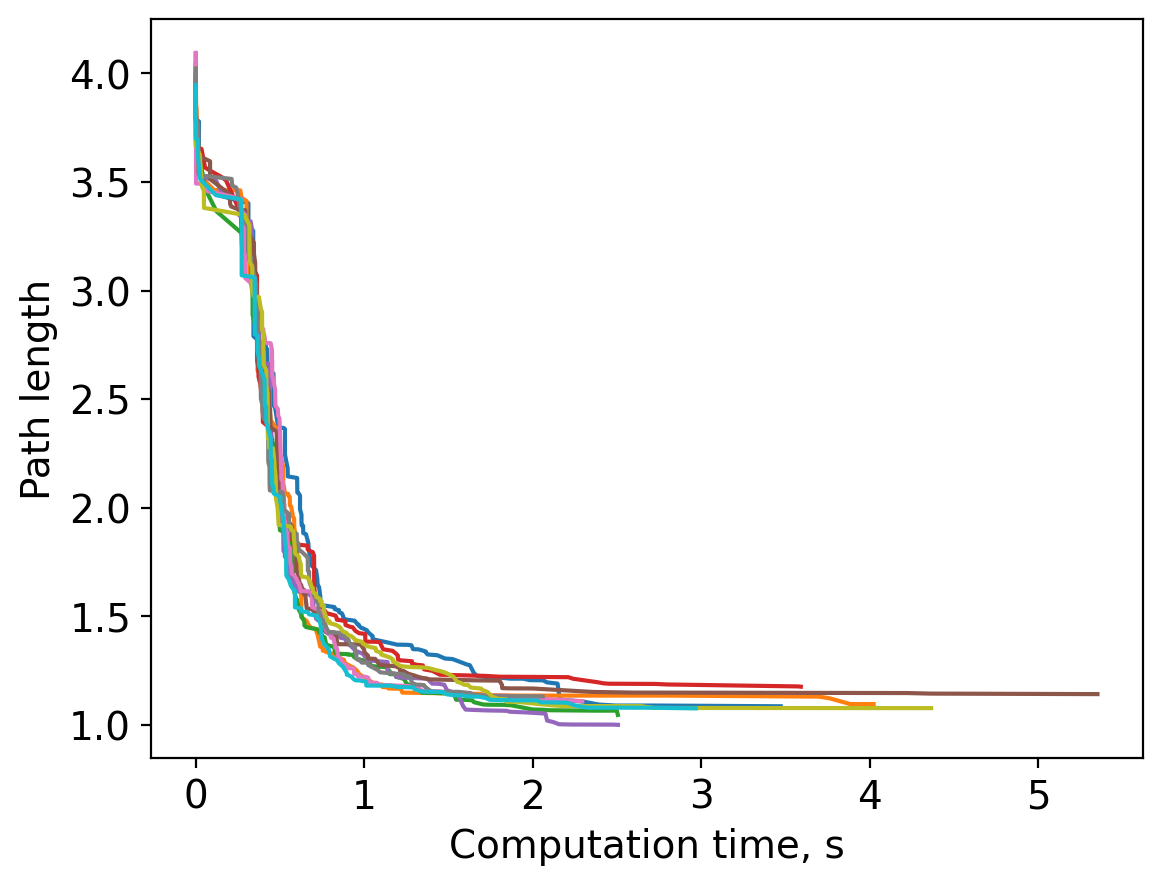

In [27]:
%%time
xlog = []
for trial in tqdm(range(10)): 
    flog = []
    t0 = time.time()
    res = dual_annealing(cost, bounds=[[0, 1]] * n, x0=x0, maxiter=1000,
                             callback=lambda x, fval, _: flog.append((time.time() - t0, fval)))
    
    plt.plot(*np.array(flog).T)
    xlog.append((res.x, res.fun))
    
plt.ylabel("Path length")
_ = plt.xlabel("Computation time, s")

In [28]:
print(res)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 1.0755345321976957
       x: [ 7.404e-01  3.416e-01 ...  1.865e-01  8.233e-01]
     nit: 1000
    nfev: 103979
    njev: 78
    nhev: 0


path len = 0.9996497260152417


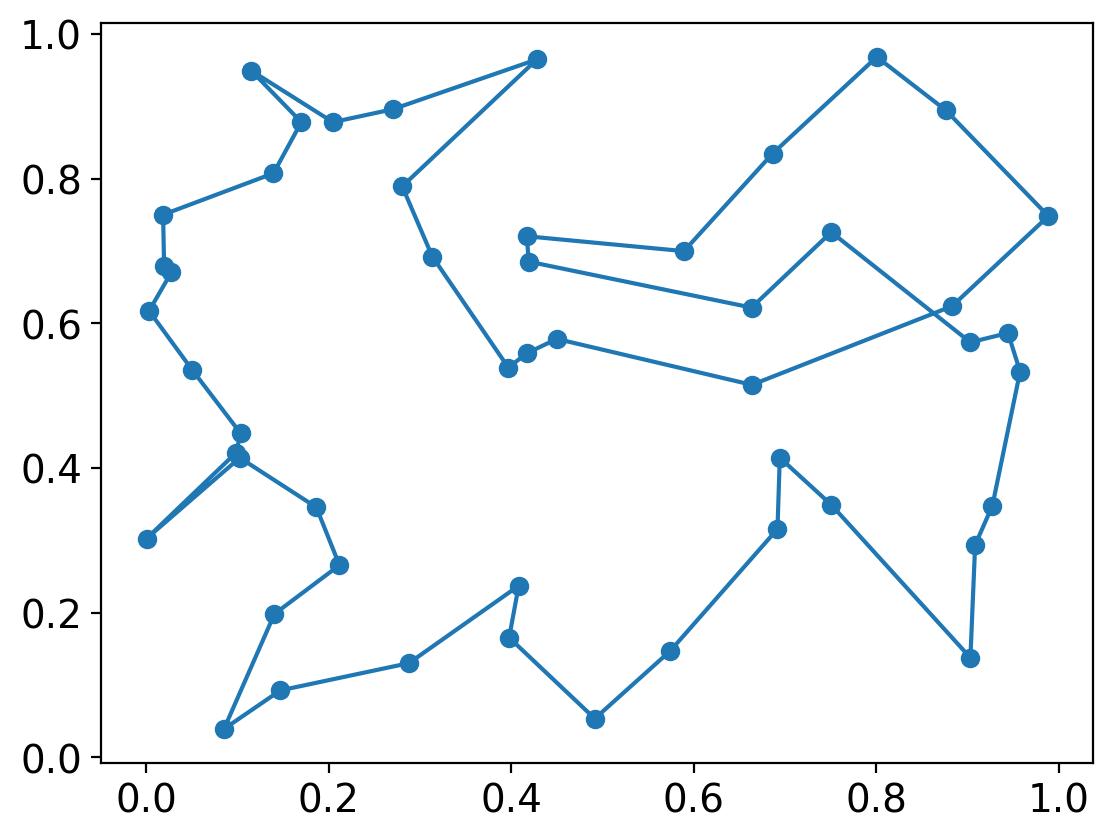

In [29]:
best_path_lens = [l[1] for l in xlog]
plot_x(xlog[np.argmin(best_path_lens)][0])

## linprog

Exmaple of Klee, Minty (1972) [[1]](https://en.wikipedia.org/wiki/Klee–Minty_cube), where simplex method's  complexity growths **exponantially** with the problem's dimension

\begin{align*}
& \max_{x \in \mathbb{R}^n} 2^{n-1}x_1 + 2^{n-2}x_2 + \dots + 2x_{n-1} + x_n\\
\text{s.t. } & x_1 \leq 5\\
& 4x_1 + x_2 \leq 25\\
& 8x_1 + 4x_2 + x_3 \leq 125\\
& \ldots\\
& 2^n x_1 + 2^{n-1}x_2 + 2^{n-2}x_3 + \ldots + x_n \leq 5^n\\
& x \geq 0
\end{align*}


In [30]:
def generate_KleeMinty_test_problem(n):
    c = np.array([2**i for i in range(n)])
    c = c[::-1]
    bounds = [(0, None) for i in range(n)]
    b = np.array([5**(i+1) for i in range(n)])
    a = np.array([1] + [2**(i+1) for i in range(1, n)])
    A = np.zeros((n, n))
    for i in range(n):
        A[i:, i] = a[:n-i]
    return -c, A, b, bounds

In [49]:
from scipy.optimize import linprog

# res = linprog(c, A, b, bounds=bounds, method="interior-point")

n_list = range(3, 14)
n_iters = np.zeros(len(n_list))
times = np.zeros(len(n_list))
for i, n in tqdm(enumerate(n_list)):
    c, A, b, bounds = generate_KleeMinty_test_problem(n)
    t0 = time.time()
    res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)}, method="revised simplex")
    n_iters[i] = res.nit
    times[i] = time.time() - t0
    

0it [00:00, ?it/s]/tmp/ipykernel_47591/3560857581.py:11: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)}, method="revised simplex")
11it [00:01,  6.15it/s]


Text(0, 0.5, 'Computation time, s')

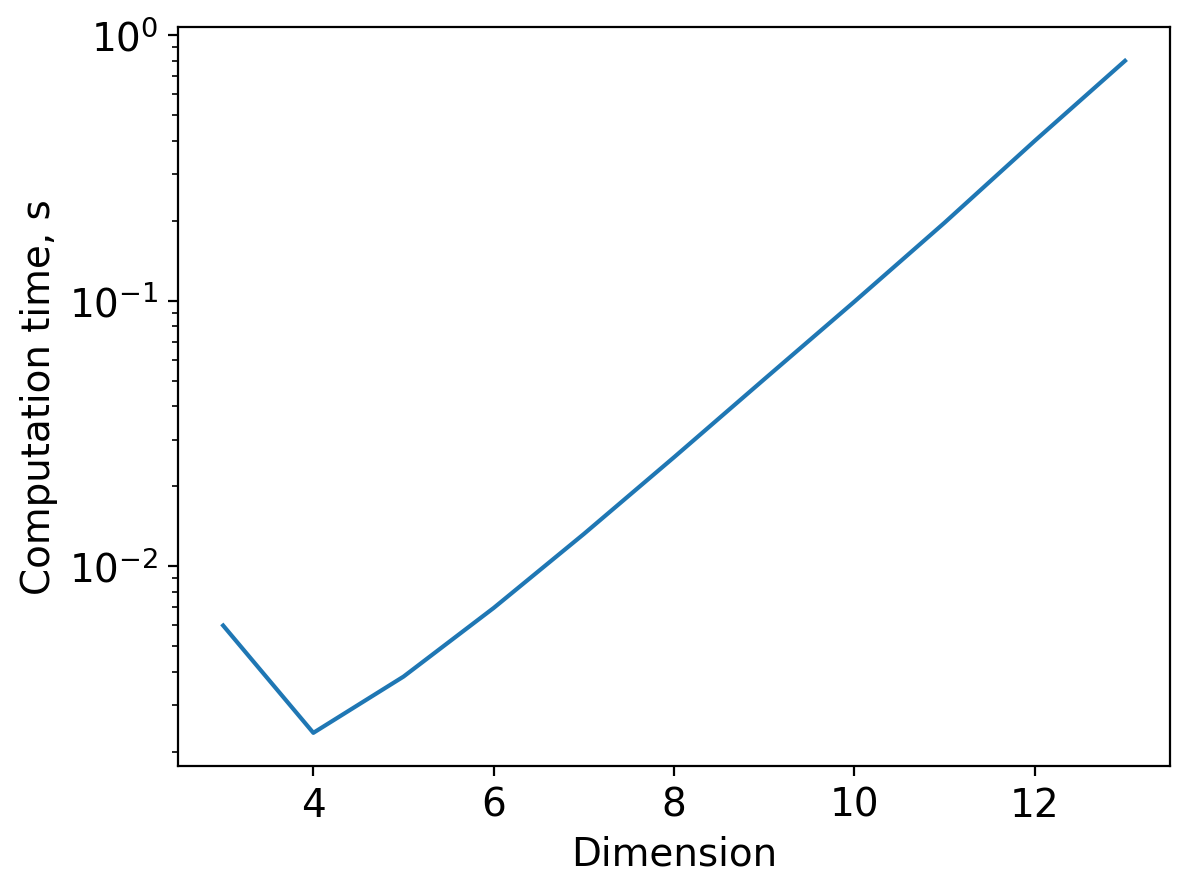

In [32]:
plt.plot(n_list, times)
plt.yscale("log")
plt.xlabel("Dimension")
plt.ylabel("Computation time, s")